# Parse XML annotation file with X,Y coordinates and instance ID into a DataFrame

In [1]:
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def xml_to_df(xml_filepath):

    tree = ET.parse(xml_filepath)
    root = tree.getroot()
    classlist = []
    for Annotation in root.iter("Annotation"):
        for Attribute in Annotation.iter("Attribute"):
            classlist.append(Attribute.attrib.get('Name'))
    classlists = sorted(classlist)
    append_df = []
    for index, Annotation in enumerate(root.iter("Annotation")):
        for Region in Annotation.iter('Region'): #iterate over the Region so we can iterate over id 1 and 2 (two circles):
            x = np.array([Vertex.get('X') for Vertex in Region.iter('Vertex')])
            y = np.array([Vertex.get('Y') for Vertex in Region.iter('Vertex')])
            id = np.array([int(Region.get('Id'))])
            classnames = classlists[index]
            coord_dict = {"ClassNames": [classnames], "X": [x], "Y": [y], "ID": [id]}
            df = pd.DataFrame(data = coord_dict)
            df.ID = df.ID.astype(int)
            append_df.append(df)
    coord_df = pd.concat(append_df).reset_index(drop=True)
    return(coord_df)

In [3]:
# coord_df = xml_to_df(r'\\fatherserverdw\kyuex\clue images\annotations\roi\labeledmask\2022-06-07 13.18.40.xml')
# coord_df

# Convert X,Y Coordinates to Binary Mask and Read and Resize Image:

In [4]:
import openslide
import os
os.environ["OPENCV_IO_MAX_IMAGE_PIXELS"] = pow(2,40).__str__()
import cv2

def df_to_image_mask(xml_filepath, ndpi_filepath,downsample_factor):
    coord_df = xml_to_df(xml_filepath)
    slide = openslide.open_slide(ndpi_filepath)
    rgb_dim = slide.dimensions
    print("Dimension of level 0 of the image is: ",rgb_dim)
    slide_level_dim = slide.level_dimensions
    num_levels = len(slide_level_dim)
    print("Number of levels in this image are:",num_levels)
    factors = slide.level_downsamples
    print("Each level is downsampled by:",factors)
    blank = np.zeros(rgb_dim, dtype = np.uint8) #white
    for idx, row in coord_df.iterrows():
        xx = row.X.astype('int')
        yy = row.Y.astype('int')
        xy = list(zip(xx,yy))
        contours = np.array(xy)
        mask = cv2.fillPoly(blank, pts=[contours.astype(int)], color=idx+1)
    target_level = slide.get_best_level_for_downsample(downsample_factor)
    target_dim = slide.level_dimensions[target_level]
    rsf = [x/y for x,y in zip(rgb_dim,target_dim)]
    image_resized = slide.read_region(location=(0,0),level=target_level,size=target_dim)
    mask_resized = cv2.resize(mask,[_//round(rsf[0]) for _ in mask.shape],interpolation=cv2.INTER_NEAREST)
    return image_resized,mask_resized

# Cropping RGB Image with Mask:

In [5]:
# image,mask = df_to_image_mask(r'\\fatherserverdw\kyuex\clue images\annotations\roi\2022-06-07 13.18.40.xml',r'\\fatherserverdw\kyuex\clue images\2022-06-07 13.18.40.ndpi',10)

In [6]:
def crop_final_mask(image,mask):
    imagearr = np.array(image)
    imagearr = imagearr[:,:,:3]
    maskarr = np.array(mask)
    maskrgb = np.repeat(maskarr[:,:,np.newaxis],3,axis=2)
    for tissueID in range(1,np.max(maskrgb[:])): #from first tissue id to end
        #masking
        masktmp = mask==tissueID #boolean
        masktmp = np.repeat(masktmp[:,:,np.newaxis],3,axis=2) #change shape to match shape of imagearr
        final_image = np.multiply(imagearr,masktmp)
        #crop
        [x_crop,y_crop] = np.where(final_image[:,:,0]>0)
        cropped_final_image = final_image[np.min(y_crop):np.max(y_crop),np.min(x_crop):np.max(x_crop)]
        cropped_final_image = cropped_final_image[:,:,::-1]
        return cropped_final_image
        #cv2.imwrite(r"\\fatherserverdw\Kevin\\" + "final_image" + str(tissueID) + ".jpg",cropped_final_image)

In [7]:
# crop_final_mask(image,mask)

# Now create mask for multiple classes:

In [8]:
# coord_df_1 = xml_to_df(r'\\fatherserverdw\kyuex\clue images\annotations\12class\unhealthy_wrongbody\2022-06-07 13.18.40.xml')
# coord_df_1 = coord_df_1.drop(columns = ["ID"])
# dict = {"corneum" : 1,"spinosum": 2,"hairshaft":3,"hairfollicle":4,"smoothmuscle":5,"oil":6,"sweat":7,"nerve":8,"bloodvessel":9,"ecm":10,"fat":11,"white":12}
# coord_df_1 = coord_df_1.replace({"ClassNames": dict})
# coord_df_1.to_pxxckle(r'\\fatherserverdw\Kevin\coord_df.pkl')

coord_df_1 = pd.read_pickle(r'\\fatherserverdw\Kevin\coord_df.pkl')
coord_df_1

,ClassNames,X,Y
0,9,"[7833, 7833, 7833, 7834, 7834, 7835, 7835, 783...","[6594, 6593, 6592, 6592, 6591, 6591, 6589, 658..."
1,9,"[8596, 8597, 8597, 8598, 8598, 8600, 8600, 860...","[6019, 6019, 6018, 6015, 6014, 6014, 6013, 601..."
2,9,"[10214, 10215, 10215, 10215, 10216, 10216, 102...","[4918, 4918, 4915, 4914, 4914, 4913, 4913, 491..."
3,9,"[8993, 8992, 8991, 8990, 8990, 8989, 8988, 898...","[5313, 5313, 5313, 5313, 5315, 5315, 5315, 531..."
4,9,"[7521, 7521, 7521, 7521, 7521, 7522, 7522, 752...","[7007, 7006, 7004, 7003, 7002, 7002, 7001, 700..."
...,...,...,...
144,12,"[33402, 33404, 33405, 33406, 33406, 33407, 334...","[20590, 20590, 20590, 20590, 20591, 20591, 205..."
145,12,"[39948, 39955, 39959, 39970, 39981, 39989, 400...","[39749, 39749, 39749, 39749, 39749, 39752, 397..."
146,12,"[39193, 39189, 39185, 39181, 39178, 39178, 391...","[37963, 37963, 37974, 37978, 37982, 37986, 379..."
147,12,"[39767, 39769, 39770, 39772, 39773, 39774, 397...","[38084, 38084, 38084, 38085, 38085, 38086, 380..."


In [47]:
row.X

array(['7833', '7833', '7833', ..., '7834', '7834', '7833'], dtype='<U4')

In [68]:
#for image:
# slide = openslide.open_slide(r'\\fatherserverdw\kyuex\clue images\2022-06-07 13.18.40.ndpi')
# target_level = slide.get_best_level_for_downsample(10)
# target_dim = slide.level_dimensions[target_level]
# image = slide.read_region(location=(0,0),level=target_level,size=target_dim)
# imagearr = np.array(image)
# imagearr = imagearr[:,:,:3]
#
# xx = coord_df_1.iloc[0,1].astype("int")
# yy = coord_df_1.iloc[0,2].astype("int")
# xy = list(zip(xx,yy))
# contours = np.array(xy)
# rgb_dim = (max(xx),max(yy))
# blank = np.zeros(rgb_dim, dtype = np.uint8)
# class_number = coord_df_1.ClassNames.values[0]
# contours = contours.astype('uint8')
# mask = cv2.fillPoly(blank, pts=[contours.astype(int)], color=(int(class_number)+1))
# maskarr = np.array(mask)
# masktmp = maskarr== class_number+1
# masktmp = masktmp.astype(np.uint8) #boolean
# masktmp = np.repeat(masktmp[:,:,np.newaxis],3,axis=2)
# imagearr = cv2.resize(imagearr,np.array([int(masktmp.shape[1]),int(masktmp.shape[0])]),interpolation=cv2.INTER_NEAREST)
# final_mask = np.multiply(imagearr,masktmp)
# [x_crop,y_crop] = np.where(final_mask[:,:,0]>0)
# cropped_final_mask = final_mask[np.min(y_crop):np.max(y_crop),np.min(x_crop):np.max(x_crop)]
# plt.imshow(cropped_final_mask)
# cv2.imwrite(r"\\fatherserverdw\Kevin\multiple_class\\" + "final_mask" + str(idx) + ".jpg",cropped_final_mask)


# for loop:

slide = openslide.open_slide(r'\\fatherserverdw\kyuex\clue images\2022-06-07 13.18.40.ndpi')
target_level = slide.get_best_level_for_downsample(10)
target_dim = slide.level_dimensions[target_level]
rsf = [x/y for x,y in zip(slide.dimensions,target_dim)]
image = slide.read_region(location=(0,0),level=target_level,size=target_dim)
imagearr = np.array(image)
imagearr = imagearr[:,:,:3]
blank = np.zeros(target_dim, dtype = np.uint8)

iter_order = [2,10,5,4,6,11,7,9,8,12,3,1]
for i in iter_order:
    coord_df_1tmp = coord_df_1[coord_df_1.ClassNames == i]
    for idx, row in coord_df_1tmp.iterrows():
        xx = row.X.astype('int32')
        yy = row.Y.astype('int32')
        # rgb_dim = (int(max(yy)),int(max(xx)))
        # xy = list(zip(xx-min(xx),yy-min(yy)))
        contours = np.array(list(zip(xx,yy)))
        contours = contours/rsf[0]
        class_number = coord_df_1.ClassNames.values[idx]
        mask = cv2.fillPoly(mask, pts=[contours.astype(int)], color=(int(class_number)))
        # maskarr = np.array(mask)
        # masktmp = maskarr == class_number #boolean
        # masktmp = np.repeat(masktmp[:,:,np.newaxis],3,axis=2)
        # masktmp = masktmp.astype(np.uint8)
        # imagearr = cv2.resize(imagearr,np.array([int(masktmp.shape[1]),int(masktmp.shape[0])]),interpolation=cv2.INTER_NEAREST)
        # final_image = np.multiply(imagearr,masktmp) # both 8265x6605x3
        # [x_crop,y_crop] = np.where(final_image[:,:,0]>0)
        # cropped_final_image = final_image[np.min(y_crop):np.max(y_crop),np.min(x_crop):800] #np.max(x_crop) is not working for some reason
        # aaa
        #cv2.imwrite(r"\\fatherserverdw\Kevin\multiple_class\\" + "final_image" + str(idx) + ".jpg",cropped_final_image)

NameError: name 'aaa' is not defined

In [ ]:
#label the binary version of constructed mask with unique pixel value for each annotation circle
#iterate thru the labeled binary mask to crop connected objects
#use the coordinate for the crop above to crop the constructed mask
#also crop the rgb image
#save both constructed mask and rgb image


[8.0, 8.0]

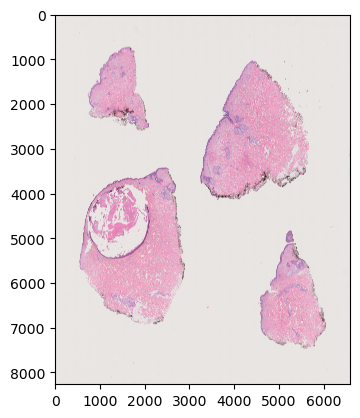

In [31]:
plt.imshow(imagearr)

In [44]:
Image.fromarray(mask)

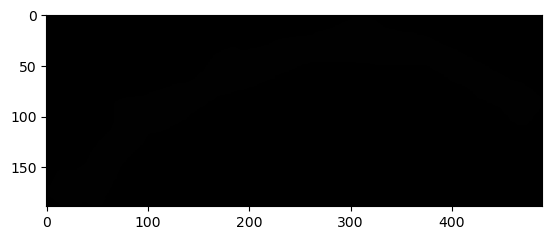

In [42]:
[xx,yy]=np.where(maskarr== class_number)
masktmp2 = masktmp[np.min(xx):np.max(xx),np.min(yy):np.max(yy)]
plt.imshow(masktmp2)

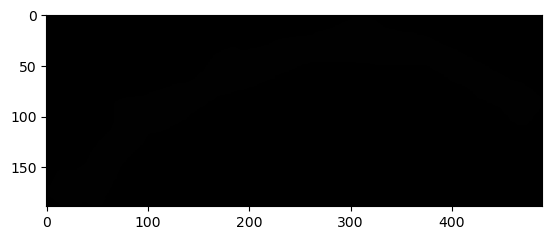

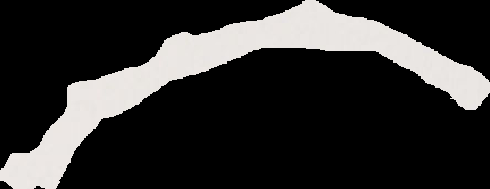

In [28]:
from PIL import Image
Image.fromarray(imagearr)

In [20]:
cropped_final_image = final_image[np.min(x_crop):np.max(x_crop),np.min(y_crop):np.max(y_crop),:]

In [29]:
np.max(cropped_final_image)

239

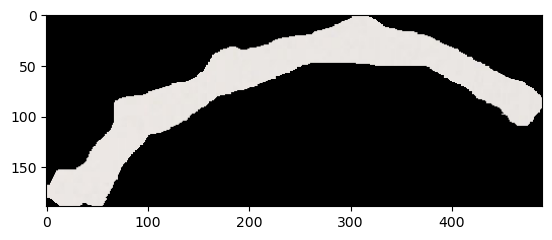

In [21]:
plt.imshow(cropped_final_image)

In [ ]:
plt.scatter(xx,yy)
#plt.scatter(coord_df_1.iloc[0,1].astype('int'),coord_df_1.iloc[0,2].astype('int'))


In [60]:
mask_of_unique_annotations #differnet annotation has differnet pixel values 1....N annotations
binary_mask = mask_of_unique_annotations>0
binary_mask_label = skimage.measure.label(binary_mask)

for idx,label in enumerate(range(1,np.max(binary_mask_label))):
    labeltmp = binary_mask_label[binary_mask_label==label]
    [x,y] = np.where(labeltmp)
    targetmask = mask_of_unique_annotations[min(x):max(x),min(y):max(y)]
    dstpth = idx+'.png'
    Image.fromarray(targetmask).save(dstpth)
    targetim = rgbim[min(x):max(x),min(y):max(y),:]





NameError: name 'mask_of_unique_annotations' is not defined